<a href="https://colab.research.google.com/github/fernandoGitHub/ML_Projects/blob/main/Deep%20Learning/Deep_Neural_Networks-Intermediate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Library

In this second notebook we will add more power to the network by adding the following capabilities:


1.   He initialization
2.   Regularization
3.   Learning Rate Decay
2.   Solver Optimizations





<a name='1'></a>
## 1 - Packages & Utils

In [1]:
!pip install -Uqq ipdb
import ipdb
%pdb on

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import pandas as pd

#from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2


In [3]:
def load_dataset(dataset='circles', n_train_samples=300, n_test_samples=100, train_noise=.05, test_noise=.05):
    if dataset != 'circles':
      return None, None, None, None

    train_X, train_Y = sklearn.datasets.make_circles(n_samples=n_train_samples, noise=train_noise)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=n_test_samples, noise=test_noise)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

In [4]:
def plot_2D_decision_boundary(model, X, Y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 0.1, X[0, :].max() + 0.1
    y_min, y_max = X[1, :].min() - 0.1, X[1, :].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    axes = plt.gca()
    axes.set_xlim([x_min, x_max])
    axes.set_ylim([y_min, y_max])
    plt.title(title)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
    plt.show()

## 2 - NN Implementation

Let's implement a Neural Network class from scrach including the following optimizations:

1.   Regularization
2.   Dropout
3.   Learning Decay
2.   More to come...

In [5]:
class DeepNeuralNetwork():

  def __init__(self):
    # Define default values
    self._W = []                    # Array of weights - e.g., W1, W2, W3, ... WL+1
    self._b = []                    # Array of biases - e.g., b1, b2, b3, ..., bL+1
    self._D = []                    # Dropout Matrices - same size as _W
    self._Z = []                    # Results of Linear transformations
    self._A = []                    # Results of Activations
    self._layers_size = [0]         # Array of layers' size (includes input and output)
    self._activations_fn = [None]   # Array of activation functions for all the layers (None for the input layer)    
    self._lambd = 0.0               # Regularization coefficient
    self._keep_prob = 1.0           # Dropout probability coefficient
    self._learning_rate = 0.01      # Initial Learning Rate
    self._decay_rate = 0.0          # Decay rate or learning over iterations

  
  def __get_layer_size(self, layer_num=None):
    """
    Returns the size of the given layer
    Arguments:
    layer_num -- int (0 -- num-layers-1) - 0 for the input layer
    """
    assert type(layer_num)==int, 'The layer num is mandatory and has to be of type int'
    assert (layer_num >= 0) and (layer_num < len(self.layers_size)), f'The accessible layer values are {0}-{len(self.layers_size)-1} - Value given: {layer_num}'

    return self._layers_size[layer_num]

  
  def infer_input_layer(self, X=None, display=False):
    """
    Adds a new input layer to the NN infering its size right from the data
    Arguments:
    X -- input vector, shape (number of features, number of examples)
    display - prints confirmation. Default = False
    """
    assert type(X) != type(None), 'The (nxm) shape X is mandatory'
    assert len(X.shape) == 2, 'The shape of X must be (nxm)'
    
    self._layers_size[0] = X.shape[0]
    if display:
      print(f'Model - added input layer \t\t Size = {self._layers_size[0]}')


  def add_hidden_layer(self, num_units=5, activation_fn='relu', display=False):
    """
    Adds a new hidden layer to the NN 
    Arguments:
    num_units -- default = 5
    activation_fn -- default = 'relu'
    display - prints confirmation. Default = False
    """
    assert num_units >= 1, 'The minimal number of layers is 1'
    assert activation_fn in ['relu', 'sigmoid', 'linear'], 'Supported activation functions are relu, sigmoid, and linear'

    self._layers_size.append(num_units)
    self._activations_fn.append(activation_fn)
    if display:
      print(f'Model - added hidden layer no: {len(self._layers_size)-1} \t Size = {num_units} \t Activation function = {activation_fn}')


  def add_output_layer(self, num_outputs=1, activation_fn='sigmoid', display=False):
    """
    Adds a new output layer to the NN 
    Arguments:
    num_outputs - default = 1
    activation_fn -- default = 'sigmoid'
    display - prints confirmation. Default = False
    """
    assert num_outputs >= 1, 'The minimal number of layers is 1'
    assert activation_fn in ['relu', 'sigmoid', 'linear'], 'Supported activation functions are relu, sigmoid, and linear'

    # Assert list has input and at least one hidden layer
    self._layers_size.append(num_outputs)
    self._activations_fn.append(activation_fn)
    if display:
      print(f'Model - Added output layer \t\t Size = {num_outputs} \t Activation function = {activation_fn}')


  def __get_deep(self):
    return len(self._layers_size)

  
  def set_regularization_coefficient(self, lambd=0.1):
    self._lambd = lambd


  def set_dropout_coefficient(self, prob=0.75):
    self._keep_prob = prob


  def set_initial_learning_rate_coefficient(self, learning_rate=0.01):
    self._learning_rate = learning_rate


  def set_decay_rate_coefficient(self, decay_rate = 0.3):
    self._decay_rate = decay_rate


  def __initialize(self):
    L = self.__get_deep()
    self._W = [None] * L
    self._b = [None] * L
    self._D = [None] * L
    self._Z = [None] * L
    self._A = [None] * L

    # Index 0 is used by the input layer
    # We need to include the output layer
    for l in range(1, L):                 
      curr = self._layers_size[l]
      prev = self._layers_size[l-1]
      self._W[l] = np.random.randn(curr, prev) * np.sqrt(2/prev)       # HE initialization
      self._b[l] = np.zeros((curr, 1))

      assert self._W[l].shape == (curr, prev)
      assert self._b[l].shape == (curr, 1)
    

  def __sigmoid(self, Z):
    A = 1/(1+np.exp(-Z))
    #cache = Z
    return A  #, cache


  def __relu(self, Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    #cache = Z 
    return A #, cache


  def __relu_backward(self, dA, Z):
    #Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0  
    assert (dZ.shape == Z.shape)
    return dZ


  def __sigmoid_backward(self, dA, Z):
    #Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ


  def __linear_forward(self, A, W, b):
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    #cache = (A, W, b)
    return Z   #, cache


  def __linear_activation_forward(self, layer, keep=1.0):
    A_prev = self._A[layer-1]
    W = self._W[layer]
    b = self._b[layer]
    activation_fn = self._activations_fn[layer]
    
    Z = self.__linear_forward(A_prev, W, b)
    
    if activation_fn == "sigmoid":
        A = self.__sigmoid(Z)
    elif activation_fn == "relu":
        A = self.__relu(Z)
    
    # Implementing Dropout
    D = np.random.rand(A.shape[0], A.shape[1])
    D = (D <= keep).astype(int)
    A = np.multiply(A, D)
    A = A / keep 

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    assert (D.shape == A.shape)

    return A, D, Z


  def __model_forward(self, X):
    L = self.__get_deep()
    self._A[0] = X
    self._D[0] = np.zeros((self._A[0].shape[0], self._A[0].shape[1]))

    for l in range(1, L-1): 
      self._A[l], self._D[l], self._Z[l] = self.__linear_activation_forward(layer=l, keep=self._keep_prob)
    
    self._A[L-1], self._D[L-1], self._Z[L-1] = self.__linear_activation_forward(layer=L-1, keep=1.0)

    assert(self._A[L-1].shape == (1,X.shape[1]))     
    return self._A[L-1]


  def __compute_cost(self, AL, Y):
    m = Y.shape[1]
    W = self._W[1:]    # getting rid of W0
    regularization = np.sum([np.sum(np.square(w)) for w in W]) * self._lambd/(2*m)
    regularization = np.squeeze(regularization)
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T)) 
    cost = np.squeeze(cost) + regularization
    assert(cost.shape == ())
    return cost


  def __linear_backward(self, dZ, A_prev, W, b):
    #A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T) + (self._lambd/m) * W
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)  

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


  def __linear_activation_backward(self, dA, layer, keep=1.0):
    #linear_cache, activation_cache = cache
    W = self._W[layer]
    b = self._b[layer]
    Z = self._Z[layer]
    A_prev = self._A[layer-1]
    activation_fn = self._activations_fn[layer]

    if activation_fn == "relu":
        dZ = self.__relu_backward(dA, Z)
        
    elif activation_fn == "sigmoid":
        dZ = self.__sigmoid_backward(dA, Z)

    dA_prev, dW, db = self.__linear_backward(dZ, A_prev, W, b)
    dA_prev = np.multiply(dA_prev, self._D[layer-1])
    dA_prev = dA_prev / keep

    return dA_prev, dW, db


  def __model_backward(self, AL, Y):
    L = self.__get_deep()
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    dA = [None] * L
    dW = [None] * L
    db = [None] * L

    dA[L-1], dW[L-1], db[L-1] = self.__linear_activation_backward(dA=dAL, layer=L-1, keep=self._keep_prob)

    for l in reversed(range(1, L-1)):
      dA[l], dW[l], db[l] = self.__linear_activation_backward(dA[l+1], layer=l, keep=self._keep_prob)

    return dW, db


  def _calculate_learning_decay(self, epoch_num, epoch_total):
    learning_rate = self._learning_rate / (1 + self._decay_rate * np.floor(epoch_num / epoch_total))
    return learning_rate


  def __update_parameters(self, dW, db, learning_rate):
    L = self.__get_deep()
    # Update rule for each parameter. Use a for loop.
    for l in range(1, L):
        self._W[l] = self._W[l] - learning_rate * dW[l]
        self._b[l] = self._b[l] - learning_rate * db[l]


  def test(self, X, Y, precision=3):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas = self.__model_forward(X)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    accuracy = np.sum((p == Y)/m)
    accuracy = np.round(accuracy, precision)
    return accuracy, p


  def predict(self, X):
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    probas = self.__model_forward(X)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    return p


  def fit(self, X, Y, num_iterations = 3000, precision=3, print_cost=False):
    costs = []
    self.__initialize()                         
    print_interval = int(num_iterations / 20)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
      AL = self.__model_forward(X=X)
      cost = self.__compute_cost(AL=AL, Y=Y)
      dW, db = self.__model_backward(AL=AL, Y=Y)
      learning_rate = self._calculate_learning_decay(epoch_num=i, epoch_total=num_iterations)
      self.__update_parameters(dW, db, learning_rate=learning_rate)
              
      # Print the cost every 100 iterations
      if print_cost and (i % print_interval == 0 or i == num_iterations - 1):
          print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
      if i % 100 == 0 or i == num_iterations:
          costs.append(np.round(cost, precision))
      
    return costs


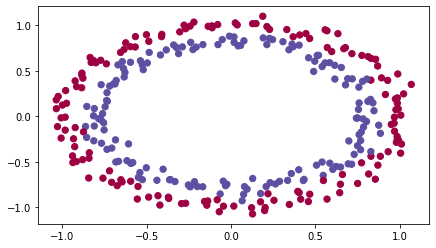

In [6]:
train_X, train_Y, test_X, test_Y = load_dataset(train_noise = .05, test_noise = .05)

In [7]:
# UNITEST
my_NN = DeepNeuralNetwork()
my_NN.infer_input_layer(train_X)
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_hidden_layer(16, 'relu')
my_NN.add_output_layer(1, 'sigmoid')
my_NN.set_dropout_coefficient(prob=1.0)
my_NN.set_regularization_coefficient(lambd=0.0)
costs = my_NN.fit(X=train_X, Y=train_Y, num_iterations=15000, print_cost=False)

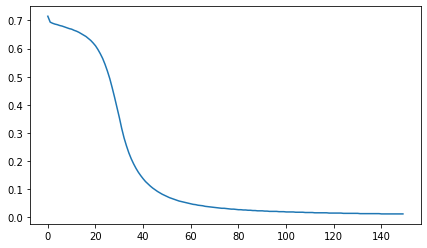

In [8]:
plt.plot(costs)

In [9]:
accuracy, pred_train = my_NN.test(X=train_X, Y=train_Y)
print(f"Cost = {costs[-1]} \t Accuracy = {accuracy}")

Cost = 0.012 	 Accuracy = 1.0


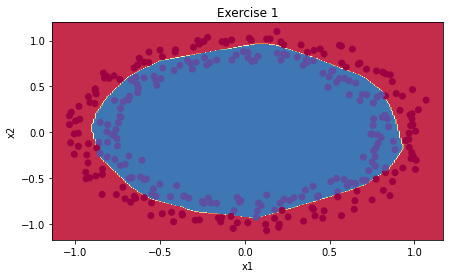

In [10]:
plot_2D_decision_boundary(lambda x: my_NN.predict(x.T), train_X, train_Y, title='Exercise 1')

In [11]:
accuracy, _ = my_NN.test(X=test_X, Y=test_Y)
print(f"Cost = {costs[-1]} ]t Accuracy = {accuracy}")

Cost = 0.012 ]t Accuracy = 0.96


<a name='3'></a>
## 3.1 - Exercise #1

At this point we don't have any indication of how a deep NN will work on this problem. Major parameters, such as the # of layers, and the size of each layer are not understood.
We will assume the NN has 3 hidden layers and we will try different layer sizes starting from 2 units per layer and growing as a factor of 2 until reaching 64.

In [12]:
def exercise_1 (train_X, train_Y, test_X, test_Y, display=False):
  results = []
  for i in range (1, 7):
    units = 2 ** i
    nn = DeepNeuralNetwork()
    nn.infer_input_layer(train_X, display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_output_layer(1, 'sigmoid', display=False)
    nn.set_dropout_coefficient(prob=1.0)
    nn.set_regularization_coefficient(lambd=0.0)
    num_iterations = 20000
    costs = nn.fit(X=train_X, Y=train_Y, num_iterations=num_iterations, print_cost=False)
    accuracy_train, pred_train = nn.test(X=train_X, Y=train_Y)
    accuracy_test, pred_test = nn.test(X=test_X, Y=test_Y)

    if display:
      print(f"Number of units in hidden layers = {units}")
      plot_2D_decision_boundary(lambda x: nn.predict(x.T), train_X, train_Y, title=f'Model with {units} units per hidden layer')
      print(f"Residual cost for {units} in hiden layers = {costs[-1]}")
      print(f"Accuracy on Train = {accuracy_train}")
      print(f"Accuracy on Test  = {accuracy_test}\n\n")

    results.append([units, costs, costs[-1], num_iterations, accuracy_train, accuracy_test])
    del nn

  return results

Number of units in hidden layers = 2


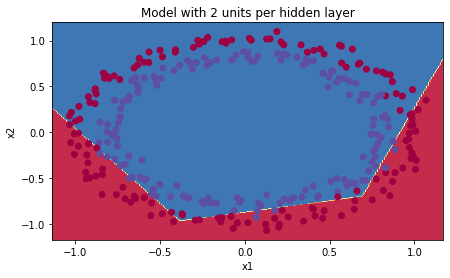

Residual cost for 2 in hiden layers = 0.48
Accuracy on Train = 0.737
Accuracy on Test  = 0.7


Number of units in hidden layers = 4


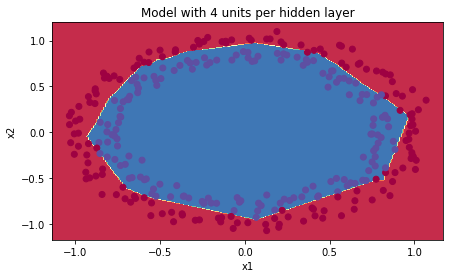

Residual cost for 4 in hiden layers = 0.076
Accuracy on Train = 0.97
Accuracy on Test  = 0.96


Number of units in hidden layers = 8


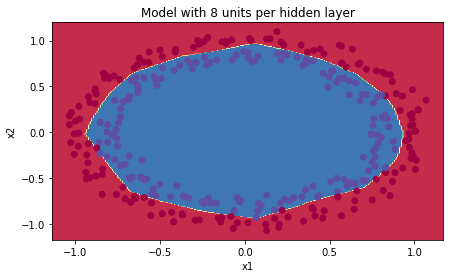

Residual cost for 8 in hiden layers = 0.021
Accuracy on Train = 0.993
Accuracy on Test  = 0.95


Number of units in hidden layers = 16


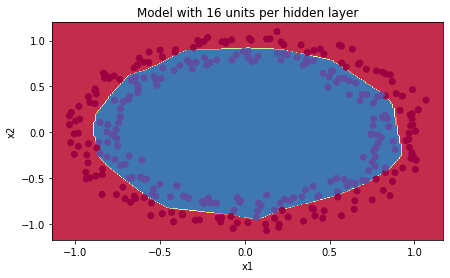

Residual cost for 16 in hiden layers = 0.005
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Number of units in hidden layers = 32


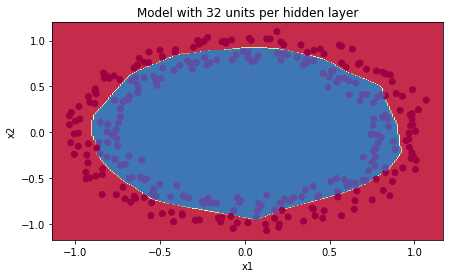

Residual cost for 32 in hiden layers = 0.003
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Number of units in hidden layers = 64


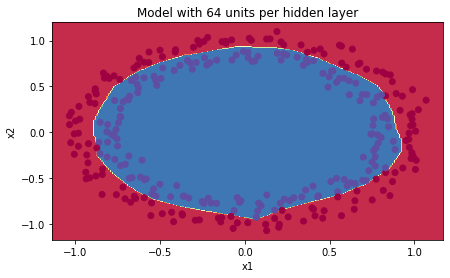

Residual cost for 64 in hiden layers = 0.003
Accuracy on Train = 1.0
Accuracy on Test  = 0.95




In [13]:
results = exercise_1(train_X, train_Y, test_X, test_Y, display=True)

In [14]:
res_df = pd.DataFrame(results, columns=['Units', 'Costs Array', 'Final Cost', 'Iterations', 'Train Acc', 'Test Acc'])
res_df = res_df.set_index('Units')
res_df.head(10)

,Costs Array,Final Cost,Iterations,Train Acc,Test Acc
Units,,,,,
2,"[1.315, 0.699, 0.689, 0.681, 0.676, 0.672, 0.6...",0.480,20000,0.737,0.70
4,"[4.069, 0.699, 0.685, 0.676, 0.669, 0.665, 0.6...",0.076,20000,0.970,0.96
8,"[0.702, 0.693, 0.69, 0.688, 0.687, 0.685, 0.68...",0.021,20000,0.993,0.95
16,"[0.763, 0.693, 0.689, 0.686, 0.684, 0.681, 0.6...",0.005,20000,1.000,0.96
32,"[0.703, 0.679, 0.67, 0.662, 0.654, 0.644, 0.62...",0.003,20000,1.000,0.96
64,"[1.171, 0.69, 0.683, 0.678, 0.673, 0.667, 0.66...",0.003,20000,1.000,0.95


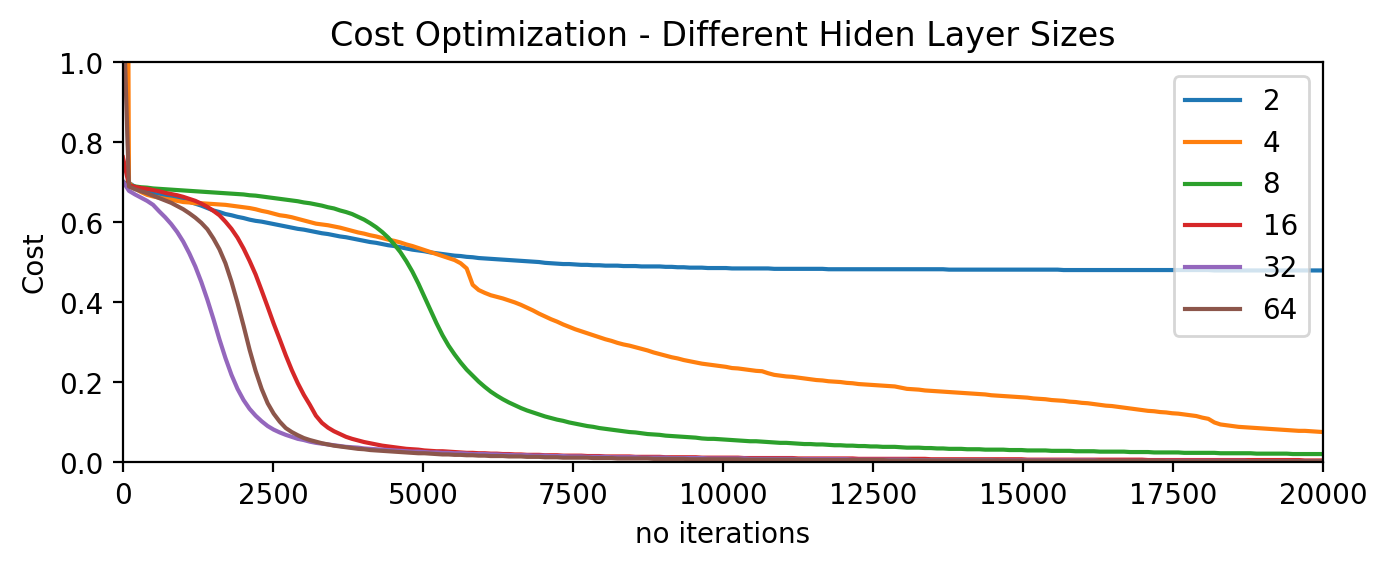

In [15]:
fig = plt.figure(figsize=(6,2),dpi=200)
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xlabel('no iterations')
ax.set_ylabel('Cost')
ax.set_title('Cost Optimization - Different Hiden Layer Sizes')

plt.xlim(0, max(res_df['Iterations']))
plt.ylim(0.0, 1.0);
for i in range(0, res_df.shape[0]):
  y = res_df.iloc[i]['Costs Array']
  x = np.linspace(0, res_df.iloc[i]['Iterations'], len(y))
  ax.plot(x, y, label=res_df.index[i])

ax.legend(loc=1)

**Exercise 1 - Summary**

We tested different hidden layer sizes and we discovered the model seems to perform at its best when the number of layers > 32. However, the model performs almost identically when layers = 16 and there is a better chance of avoiding high variance while improving performance. 

Therefore, for the next exercises we will use layers = 16.

<a name='3'></a>
## 3.2 - Exercise #2

Now we know that a network with 8-units hidden layers is performing quite well, beating other larger networks after 15K iterations.
In the following exercise, we will test different regularization coefficients and see how they affect the converging and accuracy of the network

In [16]:
def exercise_2 (train_X, train_Y, test_X, test_Y, units=16, display=False):
  results = []
  for i in range (0, 6):
    lambd = 0.02*i
    nn = DeepNeuralNetwork()
    nn.infer_input_layer(train_X, display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_output_layer(1, 'sigmoid', display=False)
    nn.set_dropout_coefficient(prob=1.0)
    nn.set_regularization_coefficient(lambd=lambd)
    num_iterations = 20000
    costs = nn.fit(X=train_X, Y=train_Y, num_iterations=num_iterations, print_cost=False)
    accuracy_train, pred_train = nn.test(X=train_X, Y=train_Y)
    accuracy_test, pred_test = nn.test(X=test_X, Y=test_Y)

    if display:     
      print(f"Regularization Coefficient = {lambd}")
      plot_2D_decision_boundary(lambda x: nn.predict(x.T), train_X, train_Y, title=f'Regularization coefficient = {lambd}')
      print(f"Residual cost for coefficient (lambda = {lambd}) = {costs[-1]}")
      print(f"Accuracy on Train = {accuracy_train}")
      print(f"Accuracy on Test  = {accuracy_test}\n\n")

    results.append([lambd, costs, costs[-1], num_iterations, accuracy_train, accuracy_test])

  return results

Regularization Coefficient = 0.0


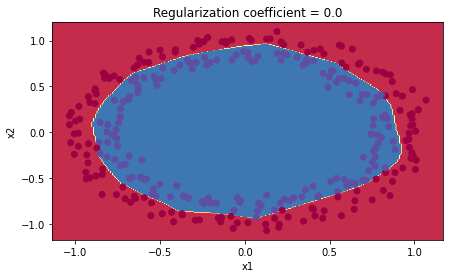

Residual cost for coefficient (lambda = 0.0) = 0.007
Accuracy on Train = 1.0
Accuracy on Test  = 0.95


Regularization Coefficient = 0.02


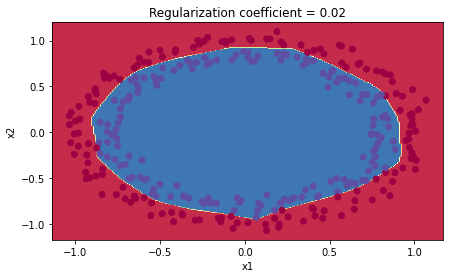

Residual cost for coefficient (lambda = 0.02) = 0.011
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Regularization Coefficient = 0.04


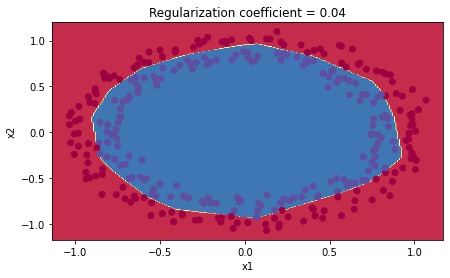

Residual cost for coefficient (lambda = 0.04) = 0.018
Accuracy on Train = 1.0
Accuracy on Test  = 0.95


Regularization Coefficient = 0.06


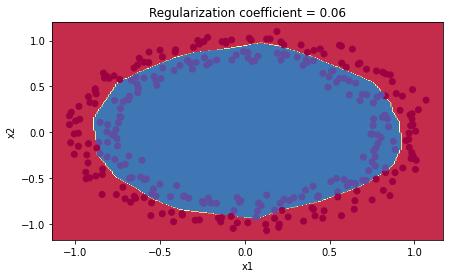

Residual cost for coefficient (lambda = 0.06) = 0.025
Accuracy on Train = 1.0
Accuracy on Test  = 0.97


Regularization Coefficient = 0.08


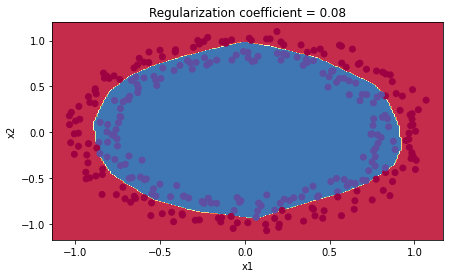

Residual cost for coefficient (lambda = 0.08) = 0.028
Accuracy on Train = 1.0
Accuracy on Test  = 0.95


Regularization Coefficient = 0.1


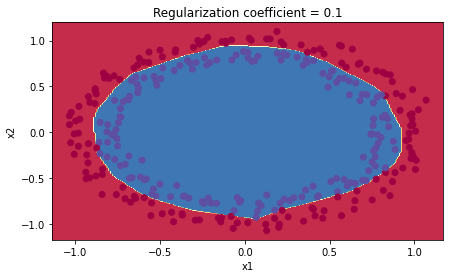

Residual cost for coefficient (lambda = 0.1) = 0.034
Accuracy on Train = 1.0
Accuracy on Test  = 0.96




In [17]:
results = exercise_2(train_X, train_Y, test_X, test_Y, units = 16, display=True)

In [18]:
res_df = pd.DataFrame(results, columns=['Regularization', 'Costs Array', 'Final Cost', 'Iterations', 'Train Acc', 'Test Acc'])
res_df = res_df.set_index('Regularization')
res_df.head(10)

,Costs Array,Final Cost,Iterations,Train Acc,Test Acc
Regularization,,,,,
0.00,"[0.694, 0.688, 0.684, 0.68, 0.676, 0.671, 0.66...",0.007,20000,1.0,0.95
0.02,"[0.722, 0.69, 0.684, 0.679, 0.675, 0.671, 0.66...",0.011,20000,1.0,0.96
0.04,"[1.211, 0.684, 0.678, 0.671, 0.663, 0.655, 0.6...",0.018,20000,1.0,0.95
0.06,"[0.78, 0.697, 0.692, 0.688, 0.685, 0.681, 0.67...",0.025,20000,1.0,0.97
0.08,"[0.747, 0.703, 0.697, 0.691, 0.686, 0.68, 0.67...",0.028,20000,1.0,0.95
0.10,"[0.774, 0.717, 0.711, 0.707, 0.704, 0.701, 0.6...",0.034,20000,1.0,0.96


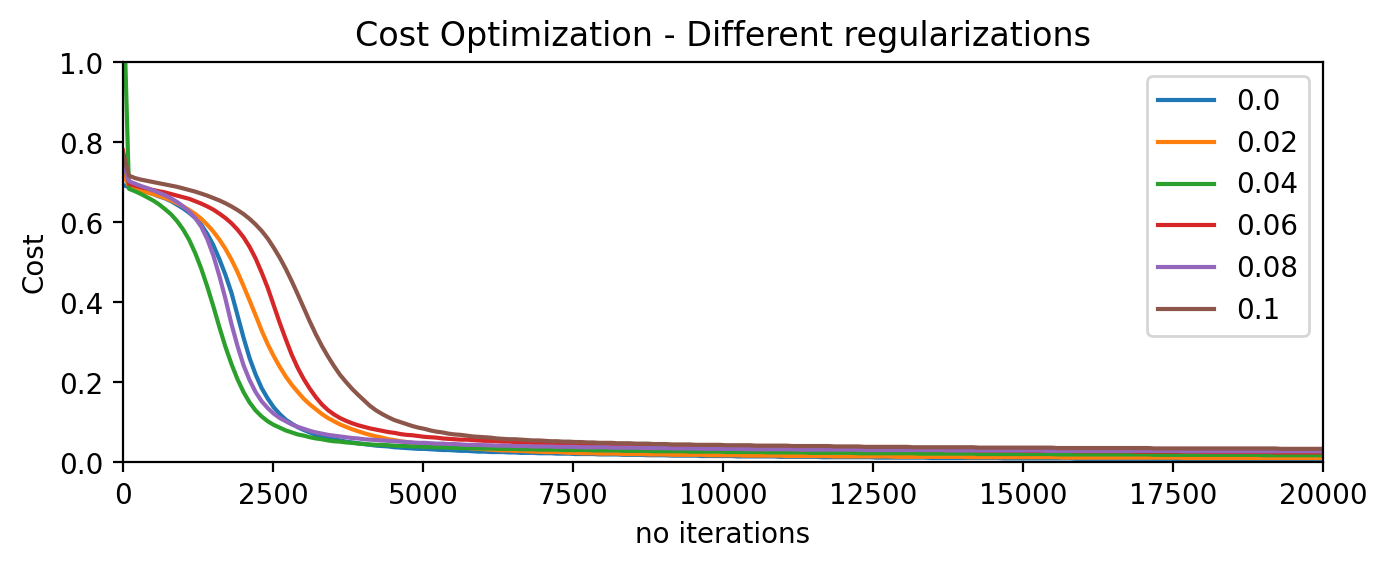

In [19]:
fig = plt.figure(figsize=(6,2),dpi=200)
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xlabel('no iterations')
ax.set_ylabel('Cost')
ax.set_title('Cost Optimization - Different regularizations')

plt.xlim(0, max(res_df['Iterations']))
plt.ylim(0.0, 1.0);
for i in range(0, res_df.shape[0]):
  y = res_df.iloc[i]['Costs Array']
  x = np.linspace(0, res_df.iloc[i]['Iterations'], len(y))
  ax.plot(x, y, label=res_df.index[i])

ax.legend(loc=1)

**Exercise 2 - Summary**

We can see clearly that the cost increases as the regularization coefficient does. Lambda = 0.02 and 0.06 are performing quite well on this dataset but the former seems to have a lower cost so we will select it for the next exercise.

We can also observe that at lambda = 0.04 we obtain the faster convergence.

<a name='3'></a>
## 3.3 - Exercise #3

Ready to get a little bit shaky? :-)
Let's play with Dropout! This, for sure, will add some action to the model fitting process.

In [20]:
def exercise_3 (train_X, train_Y, test_X, test_Y, units=16, lambd=0.02, display=False):
  results = []
  for i in range (0, 6):
    prob = 1.0 - 0.01*i
    nn = DeepNeuralNetwork()
    nn.infer_input_layer(train_X, display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_output_layer(1, 'sigmoid', display=False)
    nn.set_dropout_coefficient(prob=prob)
    nn.set_regularization_coefficient(lambd=lambd)
    num_iterations = 20000
    costs = nn.fit(X=train_X, Y=train_Y, num_iterations=num_iterations, print_cost=False)
    accuracy_train, pred_train = nn.test(X=train_X, Y=train_Y)
    accuracy_test, pred_test = nn.test(X=test_X, Y=test_Y)

    if display:     
      print(f"Dropout Coefficient = {prob}")
      plot_2D_decision_boundary(lambda x: nn.predict(x.T), train_X, train_Y, title=f'Dropout coefficient = {prob}')
      print(f"Residual cost for dropout coefficient (prob = {prob}) = {costs[-1]}")
      print(f"Accuracy on Train = {accuracy_train}")
      print(f"Accuracy on Test  = {accuracy_test}\n\n")

    results.append([prob, costs, costs[-1], num_iterations, accuracy_train, accuracy_test])

  return results

Dropout Coefficient = 1.0


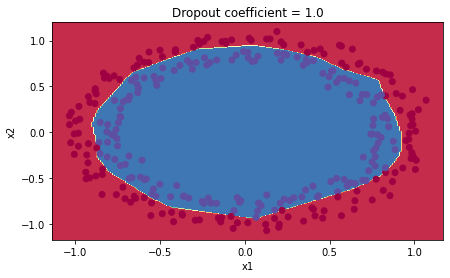

Residual cost for dropout coefficient (prob = 1.0) = 0.011
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Dropout Coefficient = 0.99


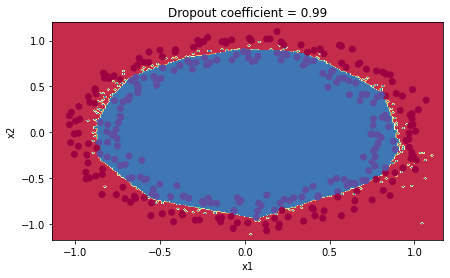

Residual cost for dropout coefficient (prob = 0.99) = 0.016
Accuracy on Train = 0.997
Accuracy on Test  = 0.95


Dropout Coefficient = 0.98


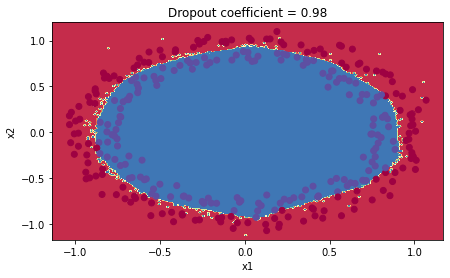

Residual cost for dropout coefficient (prob = 0.98) = 0.029
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Dropout Coefficient = 0.97


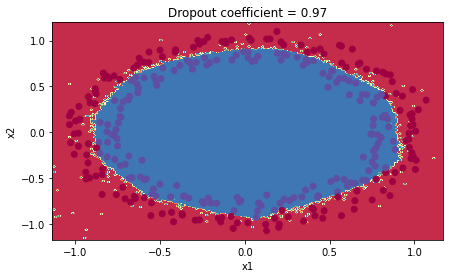

Residual cost for dropout coefficient (prob = 0.97) = 0.03
Accuracy on Train = 0.993
Accuracy on Test  = 0.93


Dropout Coefficient = 0.96


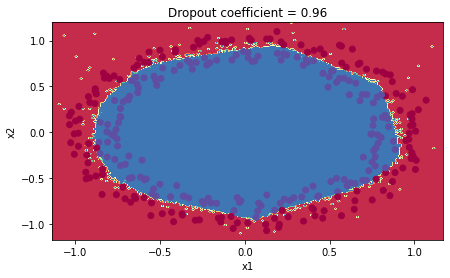

Residual cost for dropout coefficient (prob = 0.96) = 0.048
Accuracy on Train = 0.993
Accuracy on Test  = 0.94


Dropout Coefficient = 0.95


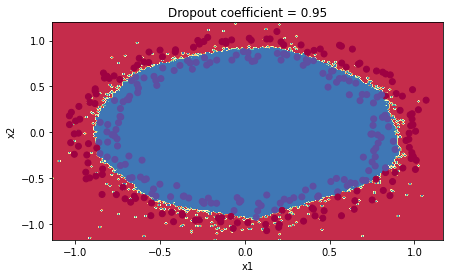

Residual cost for dropout coefficient (prob = 0.95) = 0.068
Accuracy on Train = 1.0
Accuracy on Test  = 0.96




In [21]:
results = exercise_3(train_X, train_Y, test_X, test_Y, units = 16, lambd=0.02, display=True)

In [22]:
res_df = pd.DataFrame(results, columns=['Dropout', 'Costs Array', 'Final Cost', 'Iterations', 'Train Acc', 'Test Acc'])
res_df = res_df.set_index('Dropout')
res_df.head(10)

,Costs Array,Final Cost,Iterations,Train Acc,Test Acc
Dropout,,,,,
1.00,"[0.776, 0.708, 0.698, 0.693, 0.689, 0.686, 0.6...",0.011,20000,1.000,0.96
0.99,"[0.76, 0.689, 0.682, 0.68, 0.671, 0.666, 0.671...",0.016,20000,0.997,0.95
0.98,"[0.715, 0.693, 0.691, 0.685, 0.676, 0.679, 0.6...",0.029,20000,1.000,0.96
0.97,"[0.832, 0.711, 0.719, 0.703, 0.7, 0.68, 0.705,...",0.030,20000,0.993,0.93
0.96,"[0.709, 0.699, 0.689, 0.692, 0.677, 0.688, 0.6...",0.048,20000,0.993,0.94
0.95,"[0.722, 0.688, 0.691, 0.691, 0.685, 0.679, 0.6...",0.068,20000,1.000,0.96


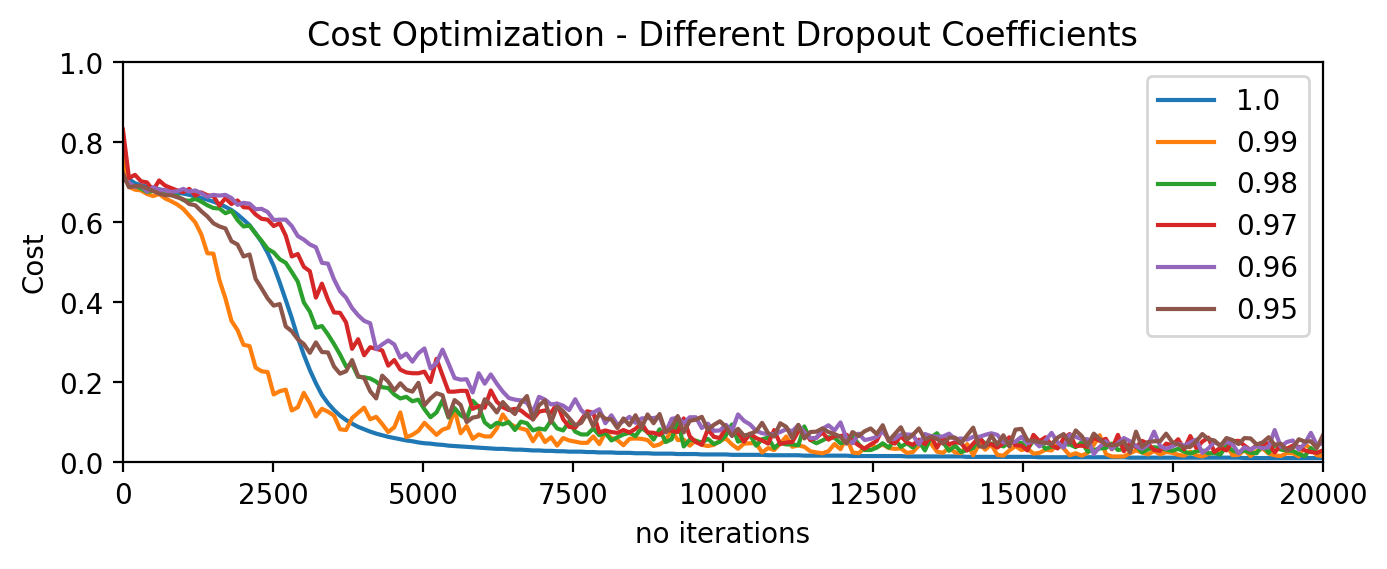

In [23]:
fig = plt.figure(figsize=(6,2),dpi=200)
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xlabel('no iterations')
ax.set_ylabel('Cost')
ax.set_title('Cost Optimization - Different Dropout Coefficients')

plt.xlim(0, max(res_df['Iterations']))
plt.ylim(0.0, 1.0);
for i in range(0, res_df.shape[0]):
  y = res_df.iloc[i]['Costs Array']
  x = np.linspace(0, res_df.iloc[i]['Iterations'], len(y))
  ax.plot(x, y, label=res_df.index[i])

ax.legend(loc=1)

**Exercise 3 - Summary**

Well... definitely kind of scary. We can see how the random process of dropout adds noise to the optimization process; yet, it can prove most valuable on more complex datasets as a way to moderate overfitting. 

Also prob = 0.99 converges pretty fast!

For the next exercises, we will turn dropout off

<a name='3'></a>
## 3.4 - Exercise #4

Let's check different values of decay rates on our model to see how it affects the training convergence


In [24]:
def exercise_4 (train_X, train_Y, test_X, test_Y, units=16, lambd=0.02, prob=1.0, initial_learning=0.01, display=False):
  results = []
  for i in range (0, 6):
    decay = np.round(0.1*i, 2)
    nn = DeepNeuralNetwork()
    nn.infer_input_layer(train_X, display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_hidden_layer(units, 'relu', display=False)
    nn.add_output_layer(1, 'sigmoid', display=False)
    nn.set_dropout_coefficient(prob=prob)
    nn.set_regularization_coefficient(lambd=lambd)
    nn.set_initial_learning_rate_coefficient(initial_learning)
    nn.set_decay_rate_coefficient(decay)
    num_iterations = 20000
    costs = nn.fit(X=train_X, Y=train_Y, num_iterations=num_iterations, print_cost=False)
    accuracy_train, pred_train = nn.test(X=train_X, Y=train_Y)
    accuracy_test, pred_test = nn.test(X=test_X, Y=test_Y)

    if display:
      print("Initial Learning Rate = 0.1")     
      print(f"Decay Coefficient = {decay}")
      plot_2D_decision_boundary(lambda x: nn.predict(x.T), train_X, train_Y, title=f'Decay Learning = {decay}')
      print(f"Residual cost for Decay Learning coefficient (decay = {decay}) = {costs[-1]}")
      print(f"Accuracy on Train = {accuracy_train}")
      print(f"Accuracy on Test  = {accuracy_test}\n\n")

    results.append([decay, costs, costs[-1], num_iterations, accuracy_train, accuracy_test])

  return results

Initial Learning Rate = 0.1
Decay Coefficient = 0.0


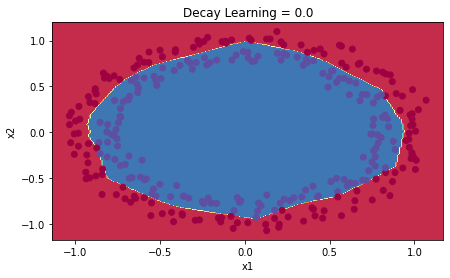

Residual cost for Decay Learning coefficient (decay = 0.0) = 0.012
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Initial Learning Rate = 0.1
Decay Coefficient = 0.1


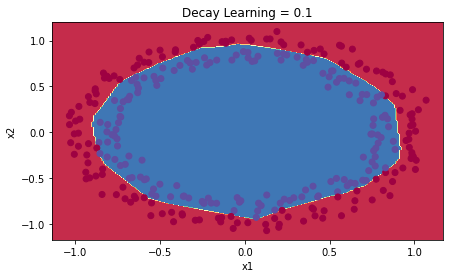

Residual cost for Decay Learning coefficient (decay = 0.1) = 0.013
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Initial Learning Rate = 0.1
Decay Coefficient = 0.2


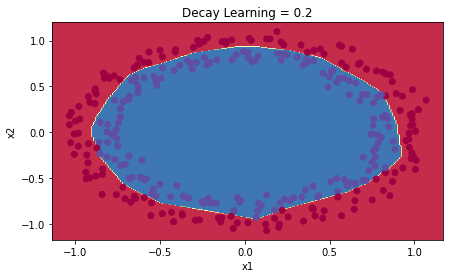

Residual cost for Decay Learning coefficient (decay = 0.2) = 0.011
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Initial Learning Rate = 0.1
Decay Coefficient = 0.3


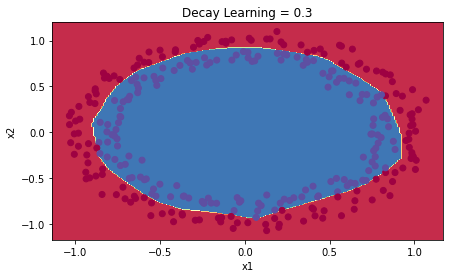

Residual cost for Decay Learning coefficient (decay = 0.3) = 0.012
Accuracy on Train = 1.0
Accuracy on Test  = 0.96


Initial Learning Rate = 0.1
Decay Coefficient = 0.4


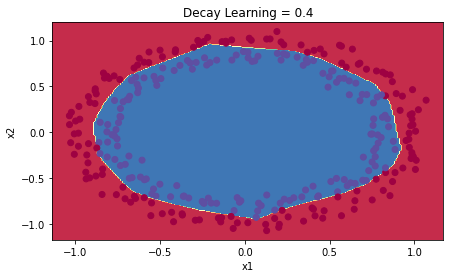

Residual cost for Decay Learning coefficient (decay = 0.4) = 0.01
Accuracy on Train = 1.0
Accuracy on Test  = 0.95


Initial Learning Rate = 0.1
Decay Coefficient = 0.5


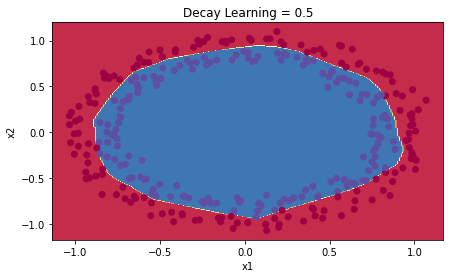

Residual cost for Decay Learning coefficient (decay = 0.5) = 0.015
Accuracy on Train = 1.0
Accuracy on Test  = 0.96




In [25]:
results = exercise_4(train_X, train_Y, test_X, test_Y, units = 16, lambd=0.02, prob=1.0, initial_learning=0.01, display=True)

In [26]:
res_df = pd.DataFrame(results, columns=['Decay', 'Costs Array', 'Final Cost', 'Iterations', 'Train Acc', 'Test Acc'])
res_df = res_df.set_index('Decay')
res_df.head(10)

,Costs Array,Final Cost,Iterations,Train Acc,Test Acc
Decay,,,,,
0.0,"[0.706, 0.693, 0.688, 0.684, 0.679, 0.675, 0.6...",0.012,20000,1.0,0.96
0.1,"[0.695, 0.691, 0.687, 0.683, 0.68, 0.676, 0.67...",0.013,20000,1.0,0.96
0.2,"[0.695, 0.687, 0.681, 0.674, 0.666, 0.657, 0.6...",0.011,20000,1.0,0.96
0.3,"[0.7, 0.696, 0.694, 0.692, 0.69, 0.689, 0.687,...",0.012,20000,1.0,0.96
0.4,"[0.711, 0.694, 0.69, 0.687, 0.683, 0.679, 0.67...",0.010,20000,1.0,0.95
0.5,"[0.725, 0.704, 0.699, 0.696, 0.694, 0.692, 0.6...",0.015,20000,1.0,0.96


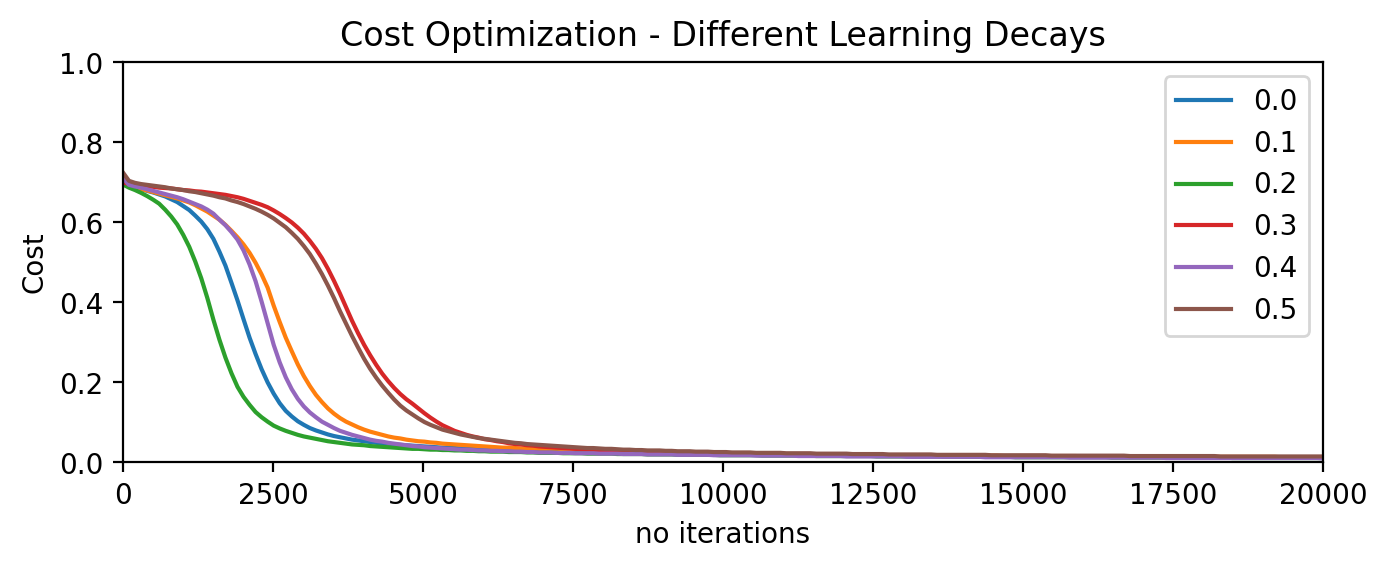

In [27]:
fig = plt.figure(figsize=(6,2),dpi=200)
ax = fig.add_axes([0, 0, 1, 1])

ax.set_xlabel('no iterations')
ax.set_ylabel('Cost')
ax.set_title('Cost Optimization - Different Learning Decays')

plt.xlim(0, max(res_df['Iterations']))
plt.ylim(0.0, 1.0);
for i in range(0, res_df.shape[0]):
  y = res_df.iloc[i]['Costs Array']
  x = np.linspace(0, res_df.iloc[i]['Iterations'], len(y))
  ax.plot(x, y, label=res_df.index[i])

ax.legend(loc=1)

**Exercise 4 - Summary**

We see that the impact on convergence is considerable while the impact on accuracy is rather small. decays 0.2 & 0.4 seem to work very well but the first one converges faster.

Next steps - Add optimizations (adams)
Check feature transformation (polar coordinates)